In [1]:
import numpy as np
from numpy.random import normal, uniform
import matplotlib.pyplot as plt
from random import random, randint, choice
from collections import defaultdict
from itertools import permutations, product
from tqdm import tqdm
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import IPython.display as display
from PIL import Image
from os import listdir

In [42]:
def generate_points(x_dist, y_dist):
    x = x_dist()[:, None]
    y = y_dist()[:, None]
    return np.concatenate([x,y], axis=1)

def draw(points, set_fig=True):
    if set_fig:
        plt.figure(figsize=(10,10))
    plt.xlim(left=-6, right=6)
    plt.ylim(bottom=-6, top=6)
    plt.scatter(points[:,0], points[:,1])
    
def uni_points(n):
    generator = lambda: uniform(-5, 5, n)
    points = generate_points(generator,generator)
    return points

def norm_points(n, m=0, std=1.5):
    generator = lambda: normal(0, std, n)
    points = generate_points(generator,generator)
    return points

def norm_groups(n, std=0.3):
    g_size = n // 9
    generators = [lambda: normal(-3, std, g_size), lambda: normal(0, std, g_size),
                  lambda: normal(3, std, g_size)]
    points = []
    for gen_x in generators:
        for gen_y in generators:
            points.append(generate_points(gen_x, gen_y))
    return np.concatenate(points, axis=0)

def get_target(points, cycle):
    """
        calculates length of cycle
        points: np.array (n, 2)
        cycle: list of indexes
    """
    n = points.shape[0]
    idx1 = cycle
    idx2 = np.roll(cycle,1, axis=0)
    diff = points[idx1,:] - points[idx2,:]
    return np.sum(np.sqrt(np.sum((diff)**2, axis=1)))

def sigmoid_temp(i, k):
    x = (i/k)*12
    return 1/(1 + np.exp(x))

def draw_solution(points, solution, set_fig=True):
    draw(points, set_fig)
    plt.plot(points[solution,0], points[solution,1])
    f, l = solution[0], solution[-1]
    plt.plot(points[[f, l], 0], points[[f, l], 1], 'C0')

In [200]:
def energy_TSP(points, k, temp_calc, get_solution=False):
    n = points.shape[0]
    state = np.array([i for i in range(n)]) # cycle with all points
    old_target = get_target(points, state)
    a, b = 0, 1
    for i in range(1, k+1):
        temp = temp_calc(i, k)
        a, b = randint(0, n-1), randint(0, n-1)
        #a, b = (a + 1) % n, (b + 1) % n 
        state[a], state[b] = state[b], state[a]
        target = get_target(points, state) 
        if target > old_target and random() > temp: # temp too low to accept worse solution
            state[a], state[b] = state[b], state[a] # reject
        else:
            old_target = target # accept
    if get_solution:
        return state
    return get_target(points, state)

In [125]:
class temperature():
    def __init__(self, parts=30):
        self.parts = parts
        self.temps = [uniform(0.1, 1) for i in range(self.parts)]
        
    def get_temp(self, i, k):
        stage = int(i/k * (self.parts -1))
        if stage==0:
            return (self.temps[0] + self.temps[1])/2
        elif stage==self.parts-1:
            return (self.temps[self.parts-1] + self.temps[self.parts-2])/2
        else:
            return (self.temps[stage+1] + self.temps[stage] + self.temps[stage-1])/3
        return self.temps[stage]
    
    def plot(self):
        y = []
        x = []
        for i in range(200):
            x.append(i/200)
            y.append(self.get_temp(i, 200))
        plt.plot(x, y)
        
    def neighbour(self):
        idx = randint(0, self.parts-1)
        multiplier = choice([0.6, 1.4])
        self.prev = (idx, self.temps[idx]) 
        self.temps[idx] = min(self.temps[idx] * multiplier, 1)
        
    def go_back(self):
        idx, val  = self.prev
        self.temps[idx] = val

In [100]:
def annealing(temperature, k, temp_calc, energy_calc, save_energies=False):
    old_energy = energy_calc(temperature.get_temp)
    energies = [old_energy]

    for i in tqdm(range(1, k+1), position=0):
        temp = sigmoid_temp(i, k)
        temperature.neighbour()
        energy = energy_calc(temperature.get_temp)
        if save_energies:
            energies.append(energy)
        if energy > old_energy and random() > temp: # temp too low to accept worse solution
            temperature.go_back() # reject
        else:
            old_energy = energy # accept
    if save_energies:
        return energies

In [208]:
points = uni_points(50)

83.74509485930213
144.62450028964005
91.02201571104486


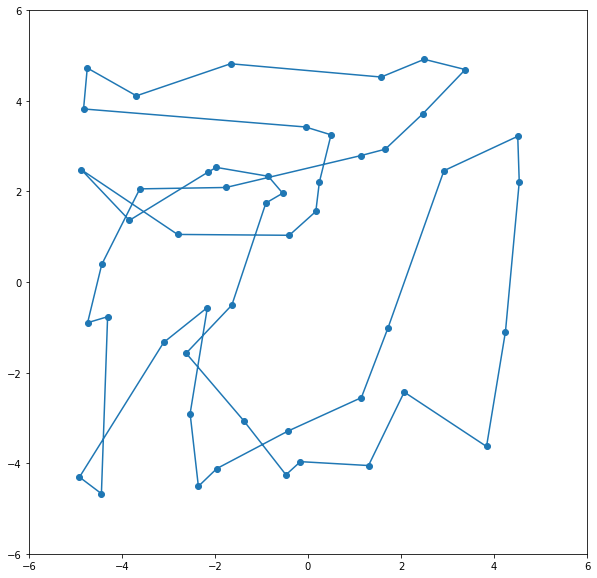

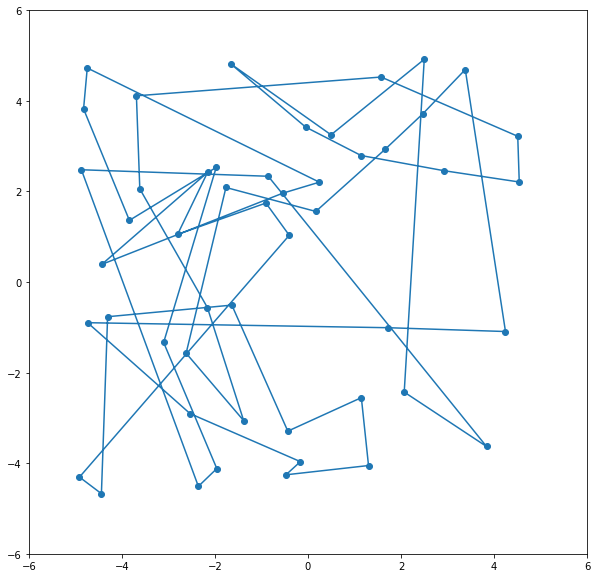

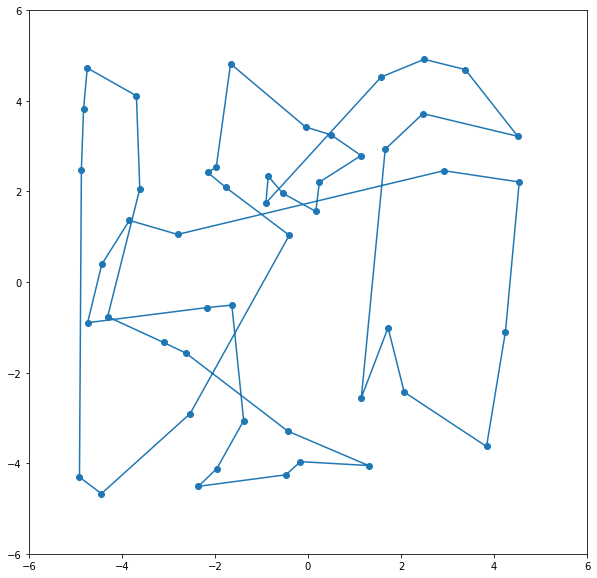

In [227]:

solution = energy_TSP(points, 5000, temp.get_temp, get_solution=True)
print(get_target(points, solution))
draw_solution(points, solution)
solution = energy_TSP(points, 5000, lambda i,k: 1-i/k, get_solution=True)
print(get_target(points, solution))
draw_solution(points, solution)
solution = energy_TSP(points, 5000, sigmoid_temp, get_solution=True)
print(get_target(points, solution))
draw_solution(points, solution)

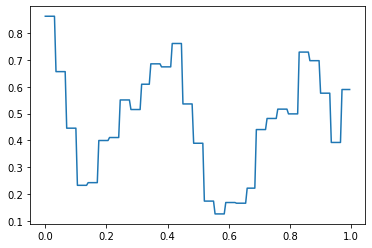

In [134]:
temp = temperature(parts=20)
temp.plot()

In [223]:
points = uni_points(50)
energy = lambda temp: energy_TSP(points, 1000, temp_calc=temp)
energies = annealing(temp, 5000, sigmoid_temp, energy, save_energies=True)

100%|██████████| 5000/5000 [07:19<00:00, 11.38it/s]


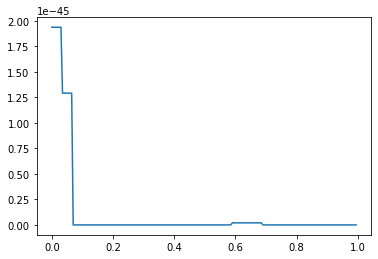

In [228]:
temp.plot()

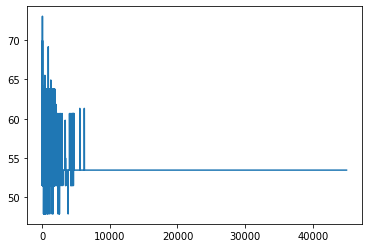

In [141]:
plt.plot(energies)